In [40]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


In [54]:
saved_data = './cached_data/'

dataset = pd.read_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='r')

mask_ttbar = dataset.type=='ttbar'
mask_singletop = dataset.type=='single_top_t_chan'
mask_wjets = dataset.type=='wjets'

# Mask that extracts the expected Asimov dataset
# Trivially the full dataset for the ttbar dataset used here, but not generally true
mask_Asimov = mask_ttbar | mask_singletop | mask_wjets
weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())

dataset_ttbar = dataset[mask_ttbar].copy()
dataset_single_top = dataset[mask_singletop].copy()
dataset_wjets = dataset[mask_wjets].copy()

nu_ttbar = dataset_ttbar.weights.sum()
print(f"expected ttbar yield = {nu_ttbar} events")

nu_singletop = dataset_single_top.weights.sum()
print(f"expected single top yield = {nu_singletop}")

nu_wjets = dataset_wjets.weights.sum()
print(f"expected wjets yield = {nu_wjets}")

expected ttbar yield = 4800157.9274200015 events
expected single top yield = 280757.92155220057
expected wjets yield = 9040966.321243158


In [55]:
path_to_ratios_wjets = './output_ratios_wjets/'
path_to_ratios_singletop = './output_ratios_singletop/'

files_wjets = glob.glob(f"{path_to_ratios_wjets}ratio_*bs512*42.npy")
files_singletop = glob.glob(f"{path_to_ratios_singletop}ratio_*bs512*.npy")

ratios = {}
ratios['wjets'] = jnp.array(np.load(files_wjets[0])[mask_Asimov])
ratios['singletop'] = jnp.array(np.load(files_singletop[0])[mask_Asimov])
ratios['ttbar'] = jnp.array(np.ones_like(ratios['wjets'])[mask_Asimov])


Neglecting the $\alpha$-dependence, we can build the model:

$$\frac{p(x|\mu)}{p_{ref}(x)} = \frac{1}{\sum_c \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot \nu_c \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

In [56]:
# Build the model

# rate term
@jax.jit
def nu(mu):

    nu = mu * nu_ttbar + nu_singletop + nu_wjets

    return nu


# per event term
@jax.jit
def log_ratio_mu(mu):

    dnu_mu = mu * nu_ttbar * ratios['ttbar']\
                + nu_singletop * ratios['singletop']\
                + nu_wjets * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu) ) 



And the test statistic function (again assuming no nuisance parameters) can be written as:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu)}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu)/p_{ref}(x)}{p(x_i|\hat{\mu})/p_{ref}(x)}$$

In [57]:
# The full NLL function
@jax.jit
def full_nll_function(mu, mu_Asimov=1.0):

    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [58]:
from iminuit import Minuit

param_vec = ['mu']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES
strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.474e+08                 │              Nfcn = 26               │
│ EDM = 0.000144 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  1.7617   │  0.0006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────┐
│    │       mu │
├────┼──────────┤
│ mu │ 4.19e-07 │
└────┴──────────┘

Text(1, 0, '$\\mu_{t\\bar{t}}$')

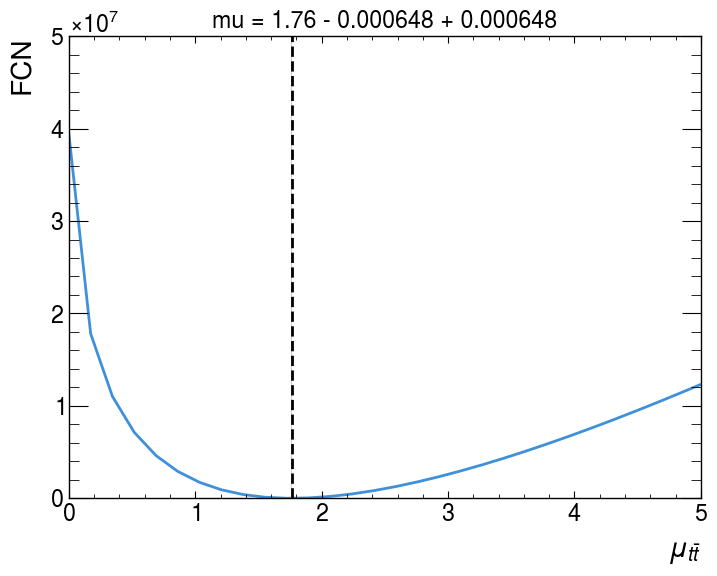

In [59]:
m1.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

So the best-fit value from the toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_{t\bar{t}} \neq \mu^\text{truth}_{t\bar{t}} = 1.0$.

Unlike a binned Poisson likelihood fit, which by definition converges to the truth value for Asimov and has well-defined asymptotic statistical properties - this is not guaranteed in an NSBI analysis.

**Adding nuisance parameters:**

Now as an example lets add unconstrained nuisance parameters to the fit - related to background modelling. Will be adding constrained nuisance parameters in a later version of the workflow.

In [47]:
# rate term
def nu(mu_vec):
    
    mu, mu_singletop, mu_wjets = mu_vec
    nu = mu * nu_ttbar \
        + mu_singletop * nu_singletop \
        + mu_wjets * nu_wjets

    return nu
    
# per event term
def log_ratio_mu(mu_vec):

    mu, mu_singletop, mu_wjets = mu_vec
    
    dnu_mu = mu             * nu_ttbar        * ratios['ttbar']\
            + mu_singletop  * nu_singletop    * ratios['singletop']\
            + mu_wjets      * nu_wjets        * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu_vec) ) 

# The full NLL function
def full_nll_function(mu):

    mu_Asimov=[1.0, 1.0, 1.0]
    
    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

To demonstrate the importance of JIT compilation in an unbinned NSBI fit, as we scale the number of parameters in the fit, we first perform a fit without any compilation:

In [48]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop', 'mu_wjets']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.497e+08                 │              Nfcn = 80               │
│ EDM = 4.6e-05 (Goal: 0.0002)     │            time = 4.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9142   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.6e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 545.69e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     4.59e-07    -62.0e-15     -0.03e-6 │
│ mu_singletop │    -62.0e-15     8.34e-16      4.4e-15 │
│     mu_wjets │     -0.03e-6      4.4e-15     7.83e-08 │
└──────────────┴────────────────────────────────────────┘

Now, lets try again with JIT compilation:

In [49]:
from iminuit import Minuit

# param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.497e+08                 │              Nfcn = 80               │
│ EDM = 4.61e-05 (Goal: 0.0002)    │            time = 1.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9142   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.6e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 545.69e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     4.59e-07    -62.0e-15     -0.03e-6 │
│ mu_singletop │    -62.0e-15     8.35e-16      4.4e-15 │
│     mu_wjets │     -0.03e-6      4.4e-15     7.83e-08 │
└──────────────┴────────────────────────────────────────┘

The fitting time is reduced by 3 times! The number of calls to the NLL function (Nfcn = 70 displayed above) can be further reduced by adding the gradient of the NLL function calculated using JAX autodiff:

In [50]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=jax.jit(jax.grad(full_nll_function)), name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.497e+08                 │         Nfcn = 26, Ngrad = 7         │
│ EDM = 7.62e-05 (Goal: 0.0002)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9142   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.5e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 545.69e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │      4.6e-07  -16.159e-15     -0.03e-6 │
│ mu_singletop │  -16.159e-15     2.75e-17    2.934e-15 │
│     mu_wjets │     -0.03e-6    2.934e-15     7.82e-08 │
└──────────────┴────────────────────────────────────────┘

The number of function calls now reduces significantly. 

# Need for JIT

While the time and function call seem negligible in this fit with only 3 parameters, JIT compilation becomes **essential** in a fit with $O(100)$ parameters typical in an LHC fit. **Without the compiled functions, the fit can go on for weeks!**

Take a look at the comparisons study we did for the ATLAS analysis:

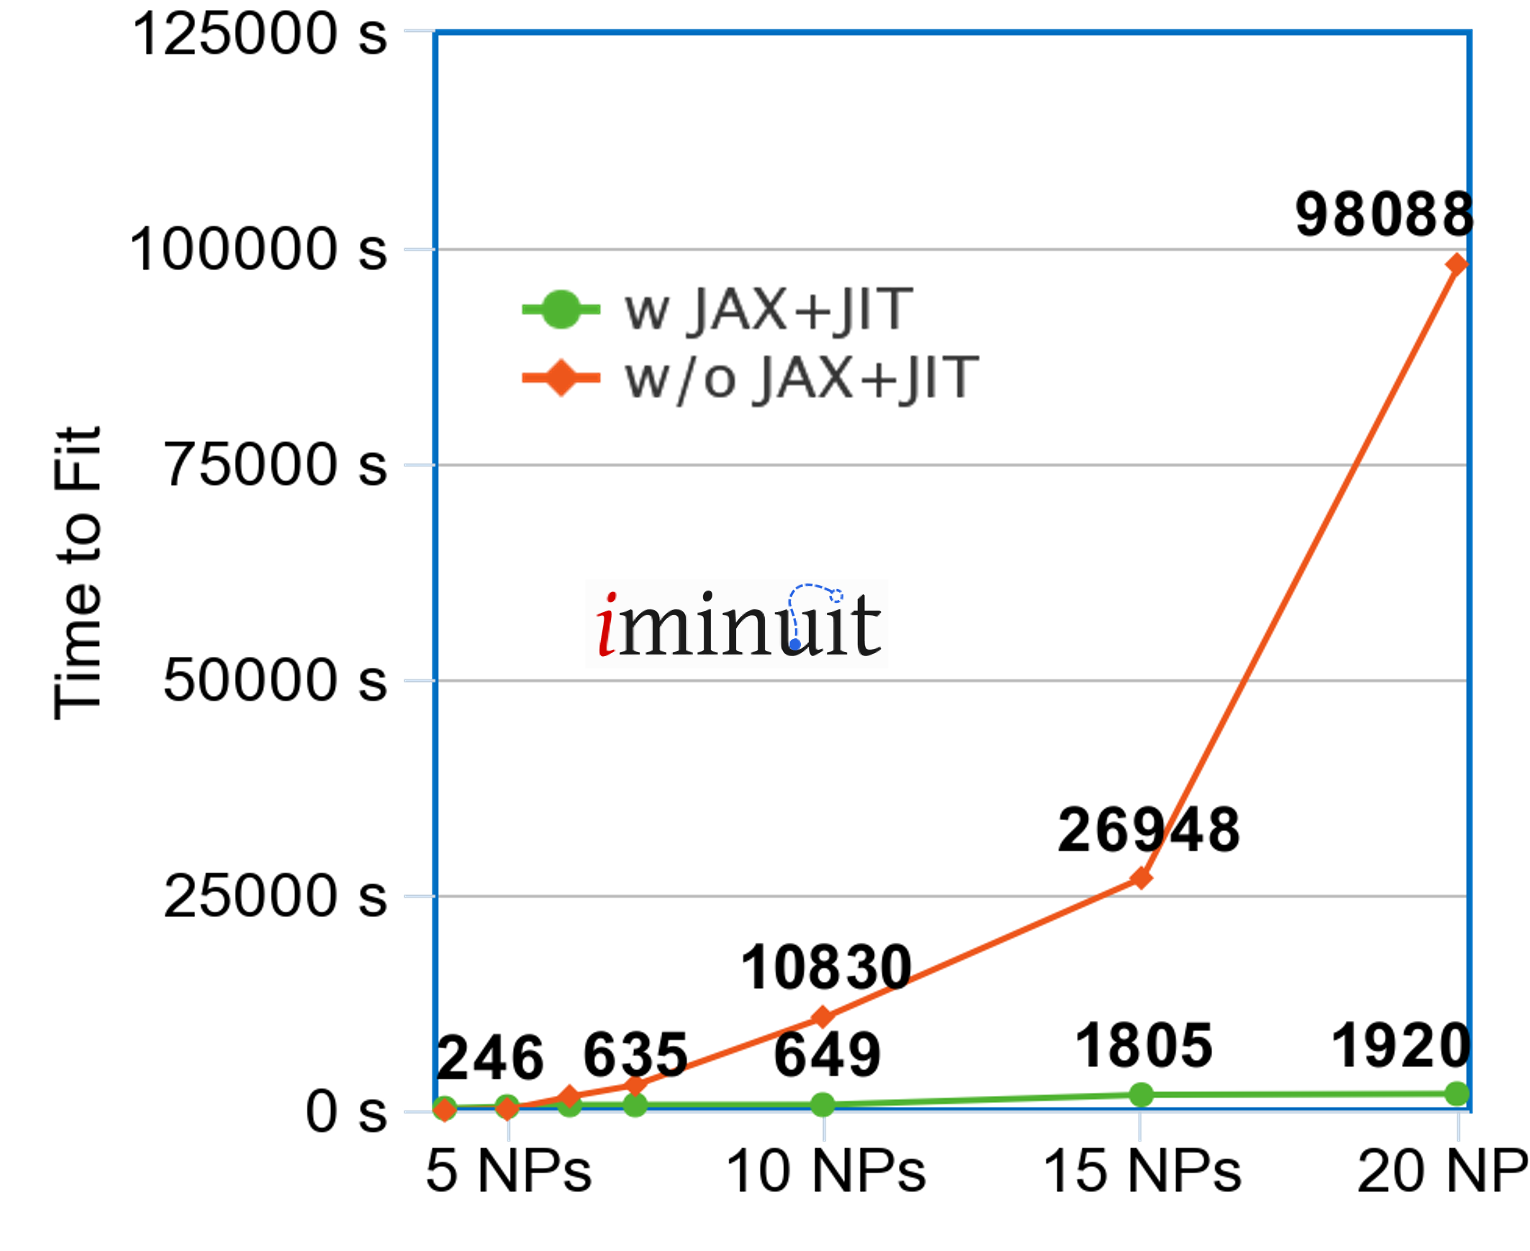


Profiled negative log-likelihood scans
===

Now adding unconstrained nuisance parameters associated with the background normalization:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\mu}}_\text{bkg})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\mu}_\text{bkg})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\mu}}_\text{bkg})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\mu}_\text{bkg})/p_{ref}(x)}$$

Text(1, 0, '$\\mu_{t\\bar{t}}$')

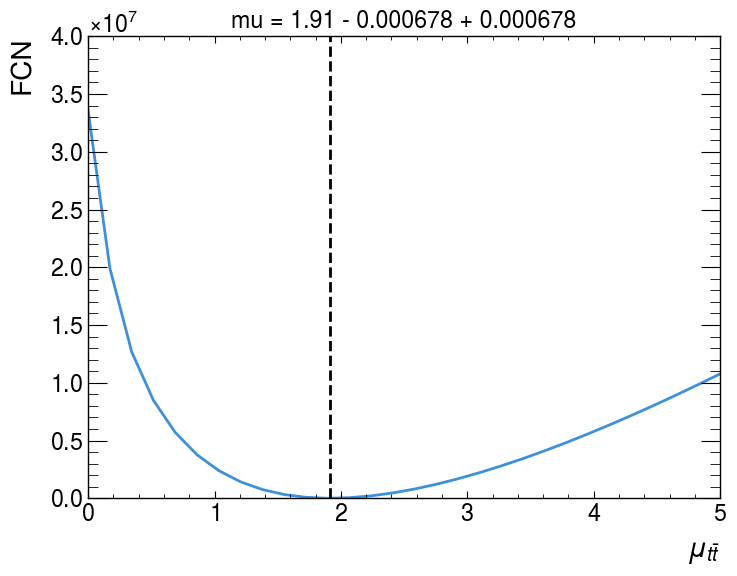

In [51]:
m1.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

Text(1, 0, '$\\mu_{t}$')

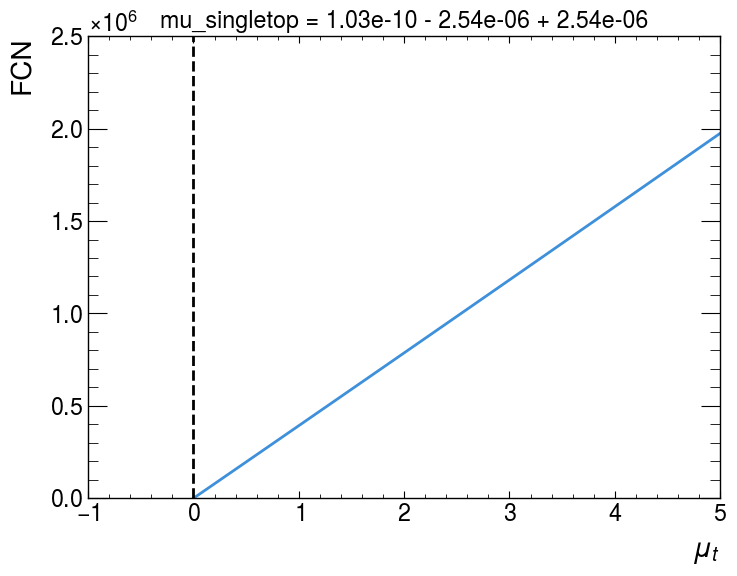

In [52]:
m1.draw_mnprofile('mu_singletop', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

Text(1, 0, '$\\mu_{t}$')

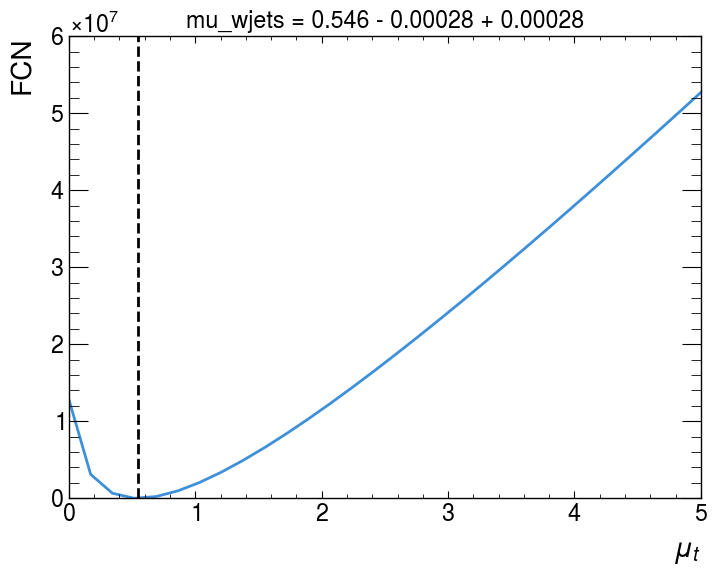

In [53]:
m1.draw_mnprofile('mu_wjets', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

Note again that the best-fit values of even the background normalization parameters in this toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_\text{bkg} \neq \mu^\text{truth}_\text{bkg} = 1.0$.

Optimizing the analysis
===

**As we increase the number of parameters, the robustness of the density ratio modelling becomes more important. Building ensembles and optimizing preselections are important. Each of the $O(100)$ nuisance paramters typical in an LHC analysis needs to be checked for bias.**

Things that can be optimized for better convergence:

- Generate more simulated events for better modelling.
- Tighter preselections - removing more of the background-rich phase space $p_{ref}\sim 0$ that can cause numerical instabilites, removing phase space regions with low Monte Carlo statistics or that are difficult to model, etc.
- Add more input features for easier signal-background separation.
- Changing the hyperparameters of the various NNs used in the modelling.
- Training larger ensembles

The workflow necessarily has to be repeated multiple times until unbiased estimators with robust statistical properties are achieved. Following is the kind of workflow built for the ATLAS analysis:

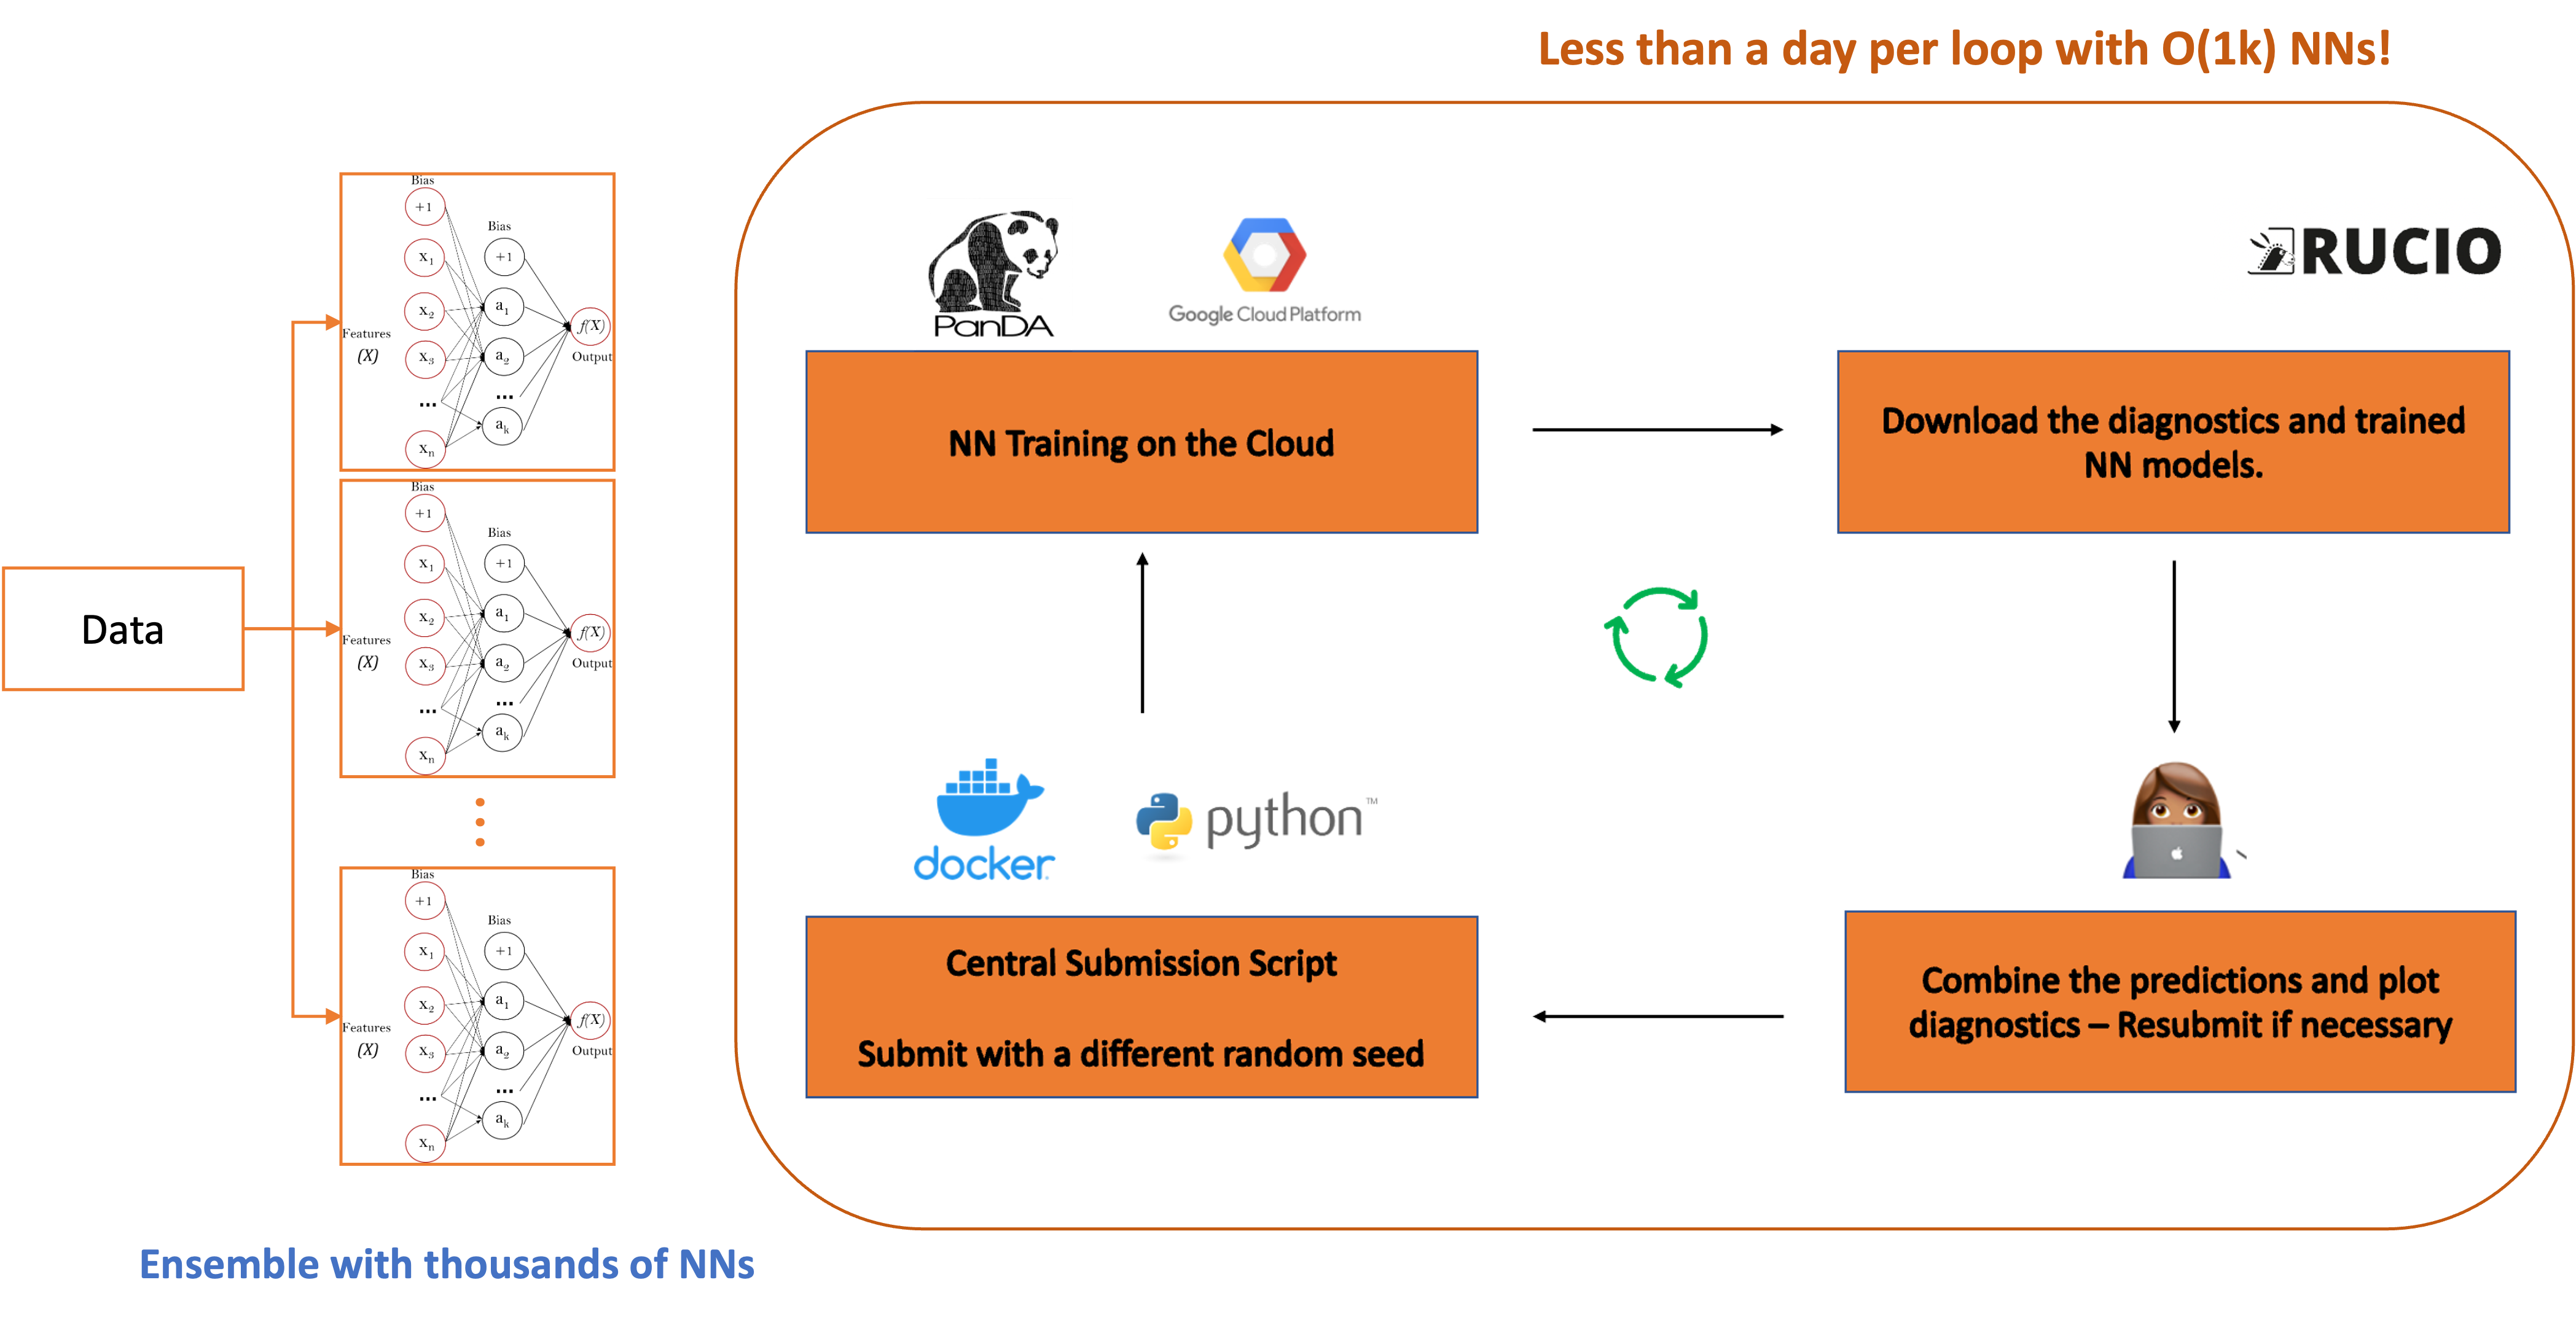




Additional modules to be added
===

- **Constrained nuisance parameters describing systematic uncertainties**

 The full test statistic is given by:

  $$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\mu}}_\text{bkg}, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\mu}_\text{bkg}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\mu}}_\text{bkg}, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\mu}_\text{bkg}, \hat{\alpha})/p_{ref}(x)} + \sum_m^{N_\text{systs}} \alpha_m^2$$

  To model these requires training two additional NN models per systematic uncertainty as explained in the `Neural_Likelihood_Ratio_training.ipynb` notebook. This module will be added soon for demonstration.
  
- **Neyman Construction**

  Neyman construction requires sampling pseudo-experiments from the Asimov dataset and fitting parameters for each of the pseudo-experiment. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS paper (https://arxiv.org/pdf/2412.01600).

  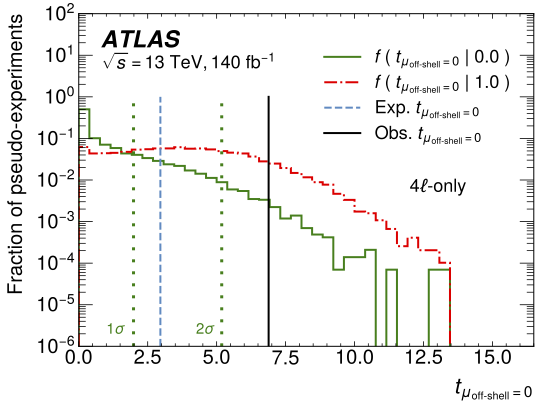

  The fitting of parameters for each of the hundreds of thousands of pseudo-experiments in a typical Neyman Construction, however, is computationally expensive and needs optimized workflows that were built for the ATLAS analysis and will be included in the tutorial soon.

- **Monte Carlo Statistical Uncertainties**

  To account for the uncertainties due to the limited Monte Carlo statistics used in the training data, a novel technique inspired by the spurious signals method and model ensembling was developed for the ATLAS publication. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS papers and the corresponding modules will be added soon (requires ensemble training).


More Diagnostics
===

- **Signal injection tests**

  By fitting parameters with truth Asimov data generated at various values of the model parameters, ensure closure of the best fit values within Monte Carlo statistical uncertainties.
  
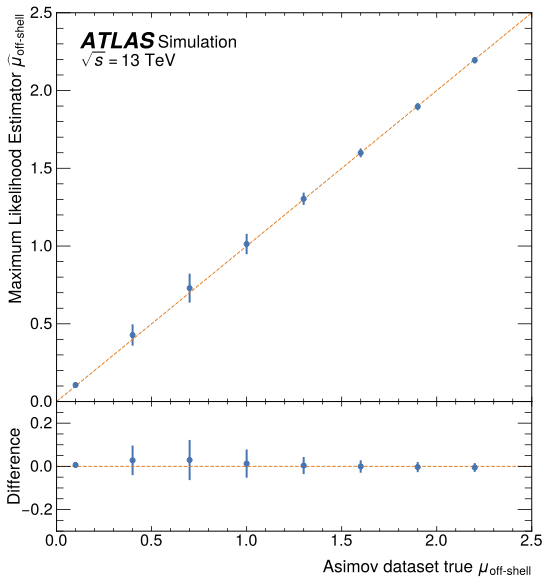

- **Data-MC validations**

  Detailed data-MC validations are perfromed both pre- and post-unblinding to verify the NNs as well as identify phase space regions associated with any data-MC differences.
  
  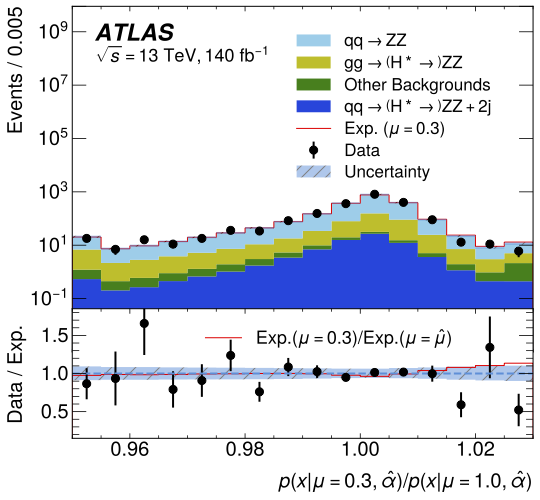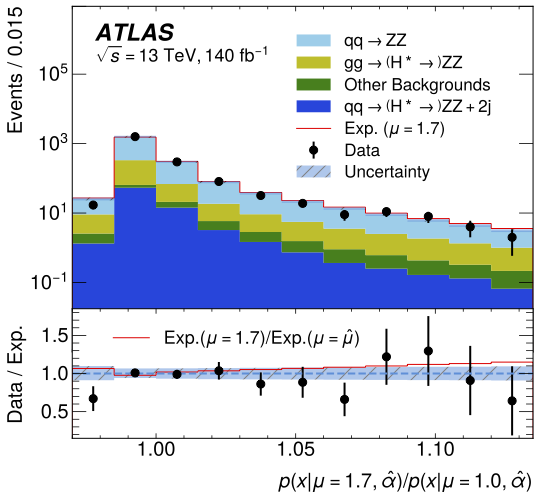

# NSBI Flowchart

A (very tentative) flowchart associated with a typical NSBI analysis:

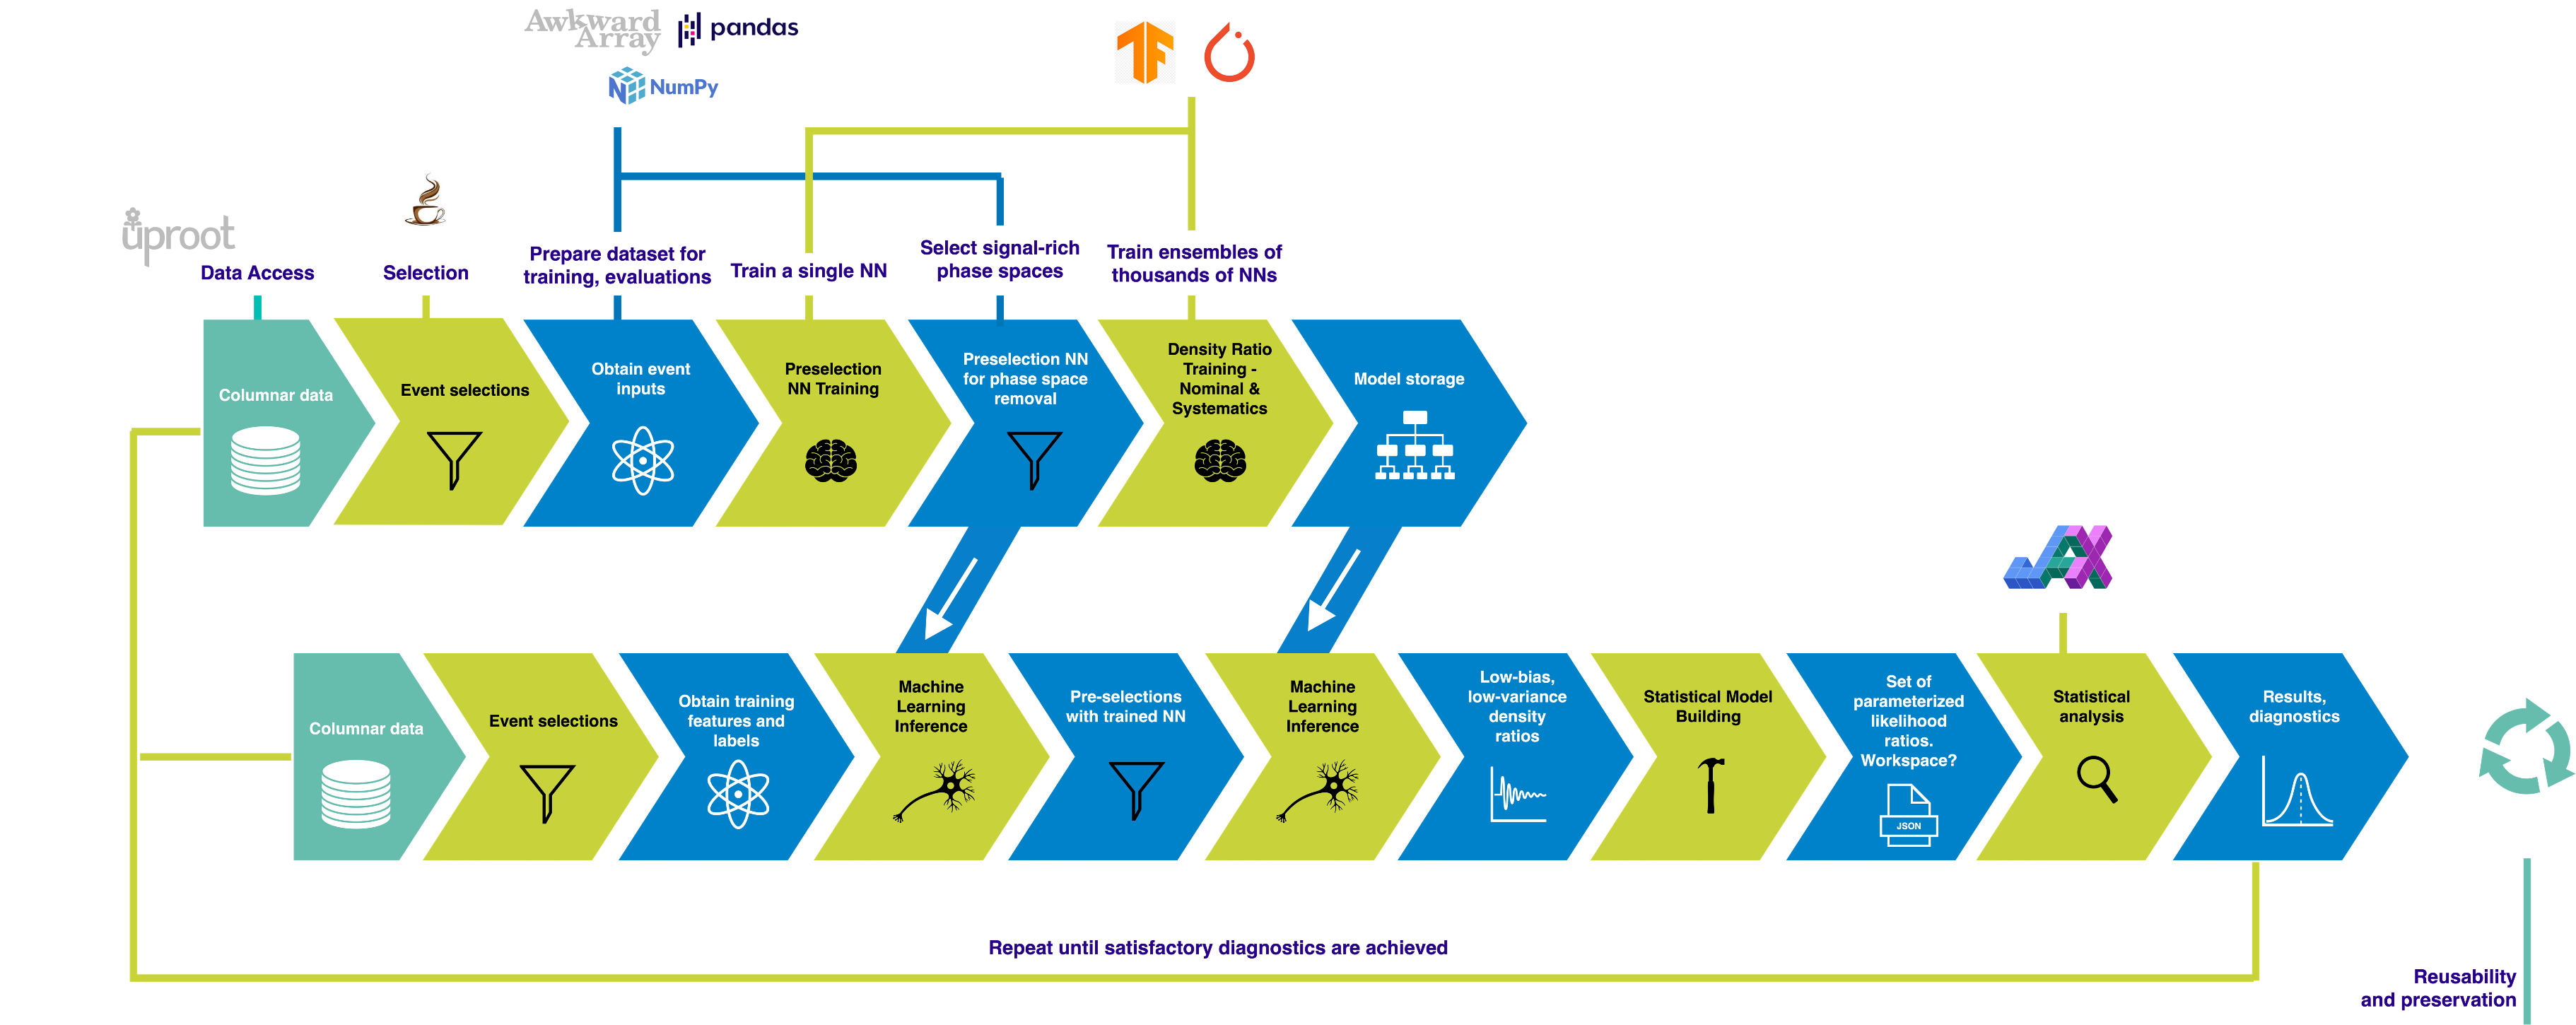